In [1]:
%reload_ext autoreload
%autoreload 2

import time
import json

import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
)
import boto3

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

## S3

In [2]:
s3_bucket = "yang-ml-sagemaker"
s3_key = "otto-product-classification"

s3_check_point = f"s3://{s3_bucket}/{s3_key}/checkpoint"

s3 = boto3.client("s3")

train_channel = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{s3_bucket}/{s3_key}/train/",
        distribution="FullyReplicated",
        s3_data_type="S3Prefix",
    )
}

train_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f7e7c4d70d0>}

## Sagemaker

In [3]:
sagemaker_session = sagemaker.Session(default_bucket=s3_bucket)
sagemaker_session
sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()
instance_type = "ml.p3.2xlarge"
instance_count = 1
train_use_spot_instances = True
max_run = 24 * 60 * 60
max_retry_attempts = 2
endpoint_name = "stacking-endpoint"

xgboost_image_uri = "722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:23.04-cuda11.8-base-ubuntu22.04-py3.10-sagemaker-xgb"
lgb_image_uri = "722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:23.04-cuda11.8-base-ubuntu22.04-py3.10-sagemaker-lgb"
stacking_image_uri = "722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:23.04-cuda11.8-base-ubuntu22.04-py3.10-sagemaker-stacking"
serving_image_uri = "722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:23.04-cuda11.8-base-ubuntu22.04-py3.10-sagemaker-serving"
model_dir = "/opt/ml/model"

## XGBoost

In [24]:
xgboost_estimator = Estimator(
    image_uri=xgboost_image_uri,
    role=role,
    instance_type=instance_type,
    instance_count=instance_count,
    max_retry_attempts=max_retry_attempts,
    volume_size=30,
    max_run=max_run,
    output_path=f"s3://{s3_bucket}/{s3_key}/model",
    sagemaker_session=sagemaker_session,
    base_job_name="xgb-training",
    use_spot_instances=train_use_spot_instances,
    max_wait=max_run,  # This should be equal to or greater than max_run
    checkpoint_s3_uri=s3_check_point + "/xgboost",
)
xgboost_estimator

### HPO

In [25]:
search_space_xgb = {
    # Pipeline hyperparameters
    "svd": CategoricalParameter(values=[1, 0]),
    "n_components": IntegerParameter(min_value=50, max_value=120),
    # XGBoost model hyperparameters
    "n_estimators": IntegerParameter(min_value=500, max_value=1700),
    "max_depth": IntegerParameter(min_value=3, max_value=15),
    "learning_rate": ContinuousParameter(
        min_value=1e-3, max_value=0.8, scaling_type="Logarithmic"
    ),
    "gamma": ContinuousParameter(min_value=1, max_value=20),
    "max_delta_step": IntegerParameter(min_value=1, max_value=20),
    "min_child_weight": ContinuousParameter(
        min_value=0, max_value=20
    ),  # Smaller values since this is a imbalanced dataset and small number of samples from a minority class can be in a leaf
    "max_leaves": IntegerParameter(min_value=0, max_value=50),
    "subsample": ContinuousParameter(min_value=0.5, max_value=0.9),
    "colsample_bytree": ContinuousParameter(min_value=0.2, max_value=0.9),
    "colsample_bylevel": ContinuousParameter(min_value=0.2, max_value=0.9),
    "colsample_bynode": ContinuousParameter(min_value=0.2, max_value=0.9),
    "reg_alpha": ContinuousParameter(min_value=0.01, max_value=100),
    "reg_lambda": ContinuousParameter(min_value=0.01, max_value=100),
    "max_bin": CategoricalParameter(values=[2**i for i in range(8, 11)]),
}

objective_metric_name_xgb = "mlogloss"
objective_type_xgb = "Minimize"
metric_definitions_xgb = [
    {
        "Name": objective_metric_name_xgb,
        "Regex": "Mean logloss score: ([0-9\\.]+)",
    }
]
xbg_base_tuning_job_name = f"xgb-hpo"

In [26]:
xgb_hpo_tuner = HyperparameterTuner(
    estimator=xgboost_estimator,
    objective_metric_name=objective_metric_name_xgb,
    hyperparameter_ranges=search_space_xgb,
    metric_definitions=metric_definitions_xgb,
    strategy="Bayesian",
    objective_type=objective_type_xgb,
    max_jobs=50,
    max_parallel_jobs=10,
    base_tuning_job_name=xbg_base_tuning_job_name,
)

In [27]:
xgb_hpo_tuner.fit(train_channel)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................

Tuning results:

In [4]:
hpo_analytics_xgb = sagemaker.HyperparameterTuningJobAnalytics(
    xgb_hpo_tuner.latest_tuning_job.name
)

hpo_results_xgb = hpo_analytics_xgb.dataframe()

hpo_results_xgb.sort_values("FinalObjectiveValue", ascending=True).head(10)

,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_bin,max_delta_step,max_depth,max_leaves,min_child_weight,...,reg_alpha,reg_lambda,subsample,svd,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,0.794658,0.900000,0.202722,1.0,0.226825,512.0,13.0,7.0,20.0,4.254775,...,0.098854,0.481863,0.686704,0.0,xgb-hpo-230618-0110-046-37876dac,Completed,0.563177,2023-06-18 01:43:40+00:00,2023-06-18 01:48:23+00:00,283.0
5,0.895920,0.818068,0.819227,1.0,0.095033,512.0,5.0,6.0,10.0,16.806646,...,0.124012,0.263193,0.705346,0.0,xgb-hpo-230618-0110-045-e346fa71,Completed,0.566608,2023-06-18 01:42:35+00:00,2023-06-18 01:48:12+00:00,337.0
29,0.571130,0.749381,0.353423,1.0,0.153059,1024.0,16.0,9.0,0.0,11.325955,...,1.335389,2.064811,0.778719,0.0,xgb-hpo-230618-0110-021-bb1908c0,Completed,0.572112,2023-06-18 01:27:33+00:00,2023-06-18 01:32:30+00:00,297.0
24,0.200000,0.900000,0.220139,1.0,0.142049,1024.0,20.0,12.0,0.0,2.765458,...,0.010000,0.454351,0.900000,0.0,xgb-hpo-230618-0110-026-459e71a2,Completed,0.575829,2023-06-18 01:28:15+00:00,2023-06-18 01:33:28+00:00,313.0
6,0.804807,0.816615,0.254495,1.0,0.235805,512.0,1.0,5.0,23.0,6.059339,...,0.114170,15.654527,0.795713,0.0,xgb-hpo-230618-0110-044-3f88796d,Completed,0.583991,2023-06-18 01:42:26+00:00,2023-06-18 01:47:14+00:00,288.0
17,0.788204,0.473749,0.811805,1.0,0.280300,512.0,1.0,3.0,39.0,5.191227,...,0.055538,0.023081,0.892494,0.0,xgb-hpo-230618-0110-033-9f69c830,Completed,0.592948,2023-06-18 01:34:30+00:00,2023-06-18 01:38:47+00:00,257.0
18,0.285590,0.487025,0.759350,1.0,0.260416,512.0,1.0,15.0,7.0,7.345877,...,0.124901,0.062224,0.725600,0.0,xgb-hpo-230618-0110-032-9d68352d,Completed,0.593065,2023-06-18 01:34:49+00:00,2023-06-18 01:39:21+00:00,272.0
19,0.224393,0.388347,0.503426,1.0,0.221741,512.0,1.0,15.0,50.0,19.794699,...,0.010000,0.787406,0.582937,0.0,xgb-hpo-230618-0110-031-73267b16,Completed,0.604724,2023-06-18 01:34:22+00:00,2023-06-18 01:38:59+00:00,277.0
16,0.591529,0.541507,0.548181,1.0,0.280464,256.0,1.0,10.0,11.0,10.245822,...,0.025238,87.553101,0.795302,0.0,xgb-hpo-230618-0110-034-6f3df955,Completed,0.620177,2023-06-18 01:34:42+00:00,2023-06-18 01:39:24+00:00,282.0
25,0.900000,0.900000,0.284278,1.0,0.402717,512.0,1.0,6.0,0.0,13.036296,...,0.010000,0.292245,0.874510,1.0,xgb-hpo-230618-0110-025-c55f22a7,Completed,0.623185,2023-06-18 01:27:47+00:00,2023-06-18 01:44:41+00:00,1014.0


Visualize results:

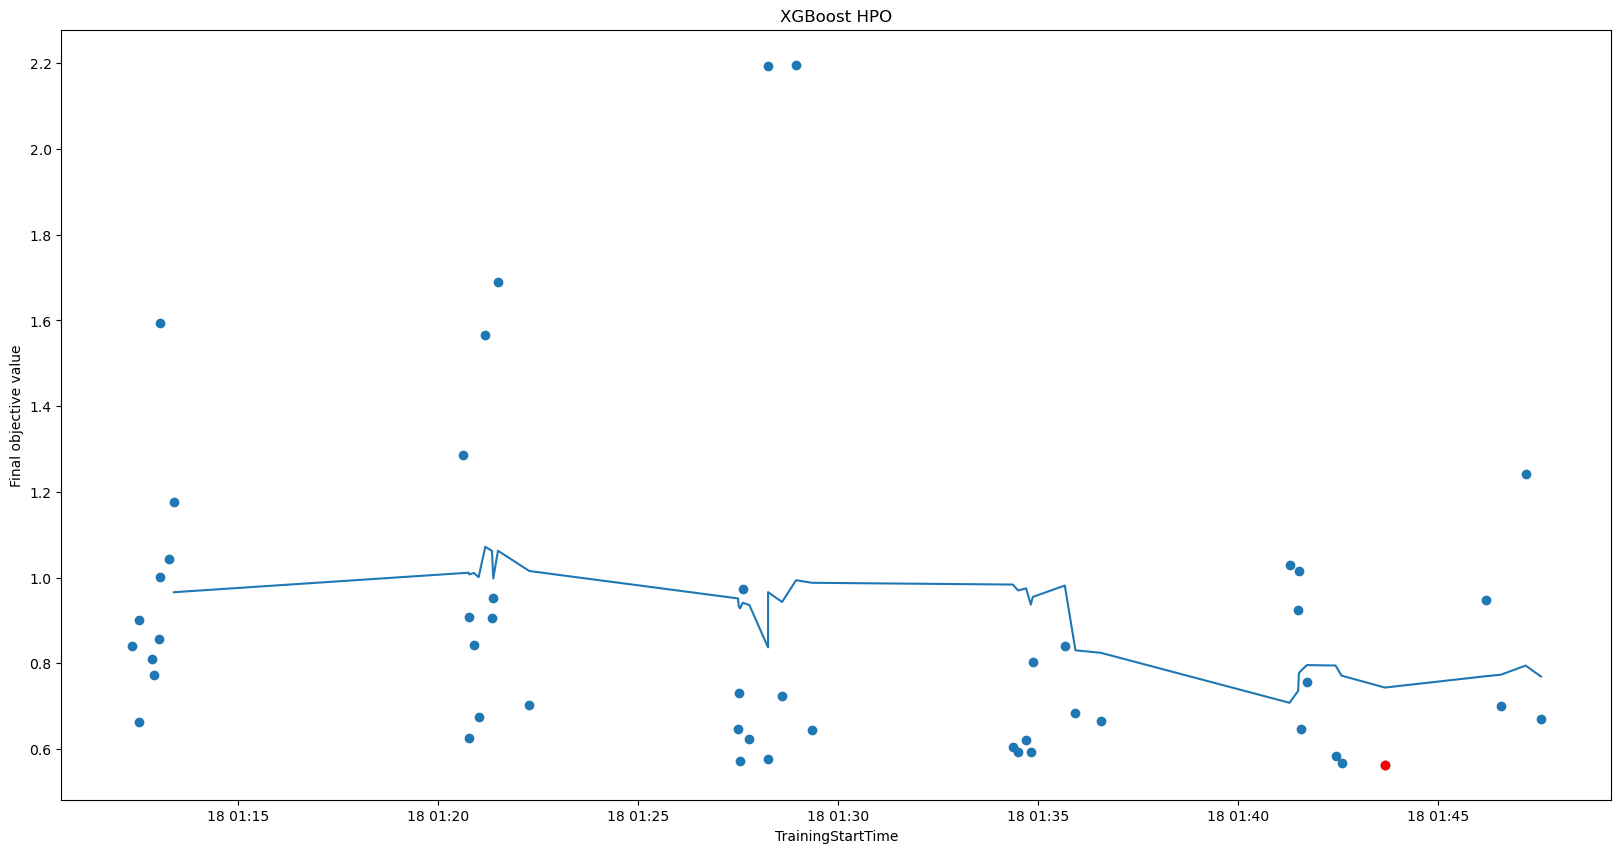

In [10]:
plt.figure(figsize=(20, 10))
# Sort by TrainingStartTime
hpo_results_xgb.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    hpo_results_xgb["TrainingStartTime"], hpo_results_xgb["FinalObjectiveValue"]
)
plt.plot(
    hpo_results_xgb["TrainingStartTime"],
    hpo_results_xgb["FinalObjectiveValue"].rolling(10).mean(),
)
# Highlight the best score in red
plt.scatter(
    hpo_results_xgb["TrainingStartTime"][
        hpo_results_xgb["FinalObjectiveValue"].idxmin()
    ],
    hpo_results_xgb["FinalObjectiveValue"].min(),
    c="r",
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("XGBoost HPO")
plt.show();

## LightGBM

In [4]:
lgb_estimator = Estimator(
    image_uri=lgb_image_uri,
    role=role,
    instance_type=instance_type,
    instance_count=instance_count,
    volume_size=30,
    max_run=max_run,
    max_retry_attempts=max_retry_attempts,
    output_path=f"s3://{s3_bucket}/{s3_key}/model",
    sagemaker_session=sagemaker_session,
    base_job_name="lgb-training",
    use_spot_instances=train_use_spot_instances,
    max_wait=max_run,  # This should be equal to or greater than max_run
    checkpoint_s3_uri=s3_check_point + "/lgb",
)
lgb_estimator

### HPO

In [9]:
search_space_lgb = {
    # Pipeline hyperparameters
    "svd": CategoricalParameter(values=[1, 0]),
    "n_components": IntegerParameter(min_value=50, max_value=120),
    # LightGBM model hyperparameters
    "learning_rate": ContinuousParameter(
        min_value=1e-3, max_value=0.8, scaling_type="Logarithmic"
    ),
    "num_iterations": IntegerParameter(min_value=500, max_value=1700),
    "num_leaves": IntegerParameter(min_value=5, max_value=200),
    "max_depth": IntegerParameter(min_value=5, max_value=15),
    "max_bin": CategoricalParameter(values=[2**i for i in range(8, 11)]),
    "max_delta_step": IntegerParameter(min_value=1, max_value=20),
    "min_gain_to_split": ContinuousParameter(min_value=0.0, max_value=15.0),
    "min_sum_hessian_in_leaf": ContinuousParameter(
        min_value=1e-3, max_value=50
    ),  # Sample weights can influence this computation
    # May be set to num_of_examples / num_leaves
    "min_data_in_leaf": IntegerParameter(min_value=100, max_value=3000),
    # Can be ignored if the dataset is large but small positive values can help with small datasets according to https://github.com/microsoft/LightGBM/issues/1244
    "lambda_l1": ContinuousParameter(min_value=0.01, max_value=100),
    "lambda_l2": ContinuousParameter(min_value=0.01, max_value=100),
    "path_smooth": IntegerParameter(min_value=100, max_value=1000),
    # Randomly select part of data (rows) without resampling
    "bagging_fraction": ContinuousParameter(min_value=0.2, max_value=0.9),
    # Every 'bagging_freq' iteration, LightGBM will randomly select 'bagging_fraction' * 100 % of the data to use for the next 'bagging_freq' iterations
    "bagging_freq": IntegerParameter(min_value=10, max_value=100),
    "feature_fraction": ContinuousParameter(min_value=0.2, max_value=0.9),
    "feature_fraction_bynode": ContinuousParameter(min_value=0.2, max_value=0.9),
    "extra_trees": CategoricalParameter(values=[1, 0]),
}

objective_metric_name_lgb = "multi_logloss"
objective_type_lgb = "Minimize"
metric_definitions_lgb = [
    {
        "Name": objective_metric_name_lgb,
        "Regex": "Mean logloss score: ([0-9\\.]+)",
    }
]
lgb_base_tuning_job_name = f"lgb-hpo"

In [13]:
lgb_hpo_tuner = HyperparameterTuner(
    estimator=lgb_estimator,
    objective_metric_name=objective_metric_name_lgb,
    hyperparameter_ranges=search_space_lgb,
    metric_definitions=metric_definitions_lgb,
    strategy="Bayesian",
    objective_type=objective_type_lgb,
    max_jobs=50,
    max_parallel_jobs=10,
    base_tuning_job_name=lgb_base_tuning_job_name,
)

In [14]:
lgb_hpo_tuner.fit(train_channel)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Tuning results:

In [16]:
hpo_analytics_lgb = sagemaker.HyperparameterTuningJobAnalytics(
    lgb_hpo_tuner.latest_tuning_job.name
)

hpo_results_lgb = hpo_analytics_lgb.dataframe()

hpo_results_lgb.sort_values("FinalObjectiveValue", ascending=True).head(10)

,bagging_fraction,bagging_freq,extra_trees,feature_fraction,feature_fraction_bynode,lambda_l1,lambda_l2,learning_rate,max_bin,max_delta_step,...,num_iterations,num_leaves,path_smooth,svd,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
9,0.900000,100.0,0.0,0.418162,0.200000,0.938043,0.022138,0.049071,1024.0,20.0,...,985.0,108.0,100.0,1.0,lgb-hpo-230618-0407-041-d925db86,Completed,0.589443,2023-06-18 04:39:44+00:00,2023-06-18 05:01:31+00:00,1307.0
8,0.900000,54.0,0.0,0.344928,0.338335,1.043641,7.456271,0.039287,512.0,20.0,...,1454.0,37.0,100.0,1.0,lgb-hpo-230618-0407-042-850fab60,Completed,0.590176,2023-06-18 04:39:35+00:00,2023-06-18 04:57:36+00:00,1081.0
2,0.900000,48.0,0.0,0.200000,0.372946,0.283264,5.783470,0.124919,1024.0,1.0,...,920.0,116.0,100.0,1.0,lgb-hpo-230618-0407-048-26cfc07c,Completed,0.612265,2023-06-18 04:40:56+00:00,2023-06-18 04:52:35+00:00,699.0
3,0.900000,23.0,0.0,0.900000,0.761735,0.011071,81.539781,0.210235,256.0,1.0,...,1447.0,71.0,100.0,1.0,lgb-hpo-230618-0407-047-ae16843a,Completed,0.630073,2023-06-18 04:40:29+00:00,2023-06-18 04:50:58+00:00,629.0
7,0.900000,40.0,1.0,0.900000,0.615086,0.476335,0.013013,0.128745,1024.0,1.0,...,986.0,163.0,100.0,1.0,lgb-hpo-230618-0407-043-6fb7f145,Completed,0.654509,2023-06-18 04:39:51+00:00,2023-06-18 04:48:44+00:00,533.0
6,0.900000,69.0,1.0,0.516244,0.200000,2.587595,0.020812,0.190730,1024.0,20.0,...,1470.0,120.0,877.0,1.0,lgb-hpo-230618-0407-044-dcdd90fe,Completed,0.775155,2023-06-18 04:40:05+00:00,2023-06-18 04:47:33+00:00,448.0
1,0.900000,25.0,1.0,0.900000,0.587864,0.347851,0.125890,0.182480,256.0,10.0,...,1036.0,35.0,315.0,0.0,lgb-hpo-230618-0407-049-ea9ee822,Completed,0.795489,2023-06-18 04:41:30+00:00,2023-06-18 04:47:38+00:00,368.0
23,0.885263,26.0,0.0,0.250654,0.346972,2.291608,0.101751,0.102172,1024.0,19.0,...,708.0,146.0,414.0,0.0,lgb-hpo-230618-0407-027-ca294d6c,Completed,0.897353,2023-06-18 04:26:31+00:00,2023-06-18 04:32:08+00:00,337.0
4,0.200000,61.0,0.0,0.234480,0.251564,1.439094,0.025667,0.039778,1024.0,20.0,...,990.0,103.0,100.0,0.0,lgb-hpo-230618-0407-046-dc033011,Completed,0.943815,2023-06-18 04:40:33+00:00,2023-06-18 04:45:40+00:00,307.0
5,0.900000,76.0,0.0,0.200000,0.343996,3.355358,1.753493,0.015446,512.0,20.0,...,616.0,25.0,565.0,0.0,lgb-hpo-230618-0407-045-d01535bc,Completed,0.956267,2023-06-18 04:40:07+00:00,2023-06-18 04:46:50+00:00,403.0


Visualize results:

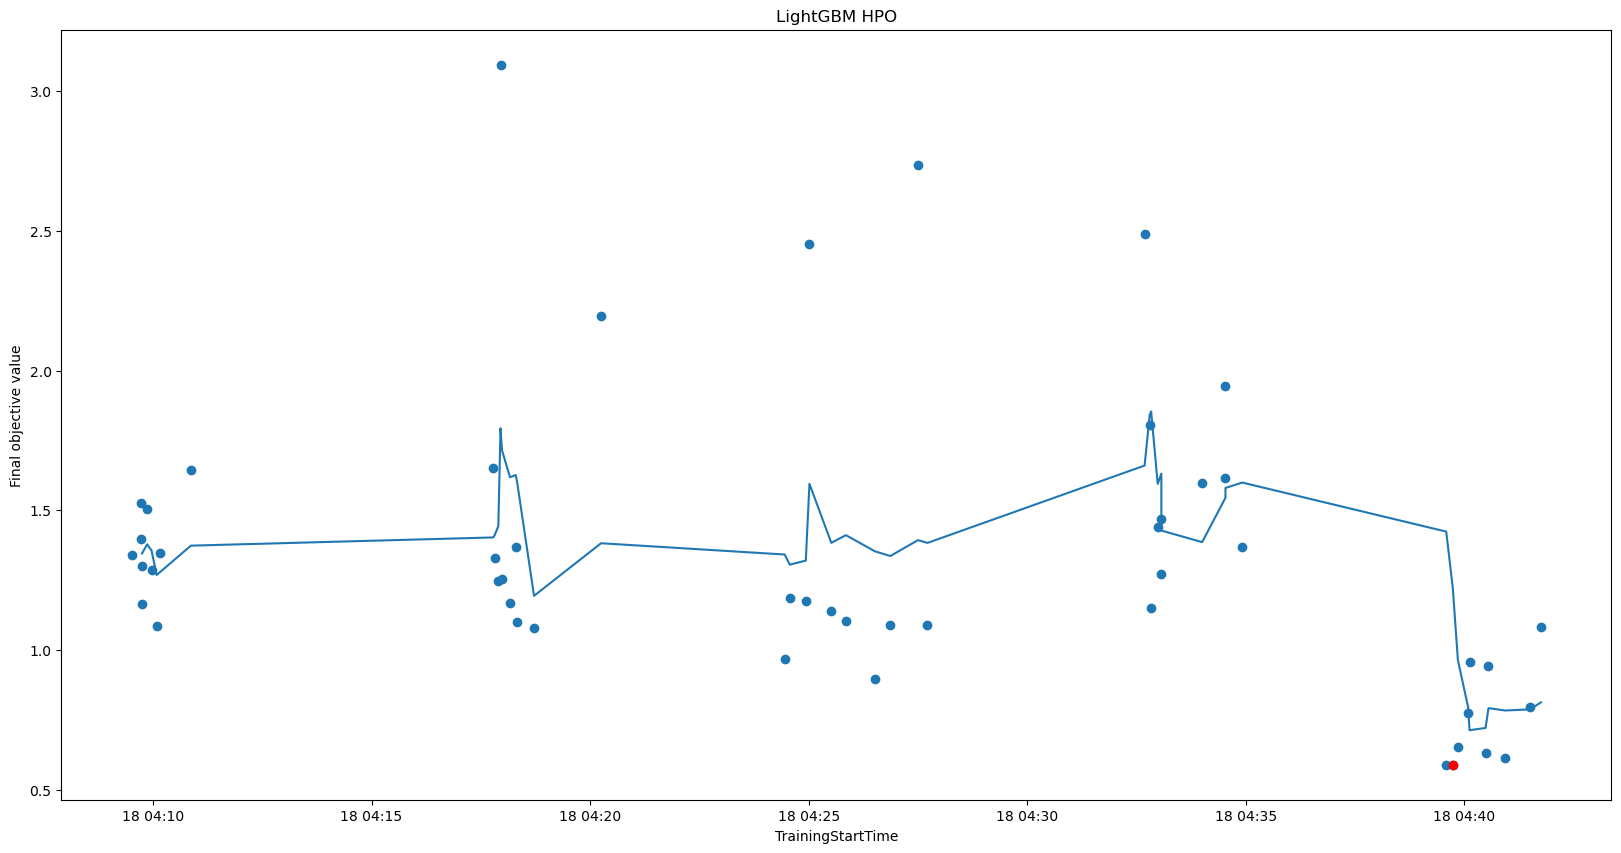

In [17]:
plt.figure(figsize=(20, 10))
# Sort by TrainingStartTime
hpo_results_lgb.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    hpo_results_lgb["TrainingStartTime"], hpo_results_lgb["FinalObjectiveValue"]
)
plt.plot(
    hpo_results_lgb["TrainingStartTime"],
    hpo_results_lgb["FinalObjectiveValue"].rolling(5).mean(),
)
# Highlight the best score in red
plt.scatter(
    hpo_results_lgb["TrainingStartTime"][
        hpo_results_lgb["FinalObjectiveValue"].idxmin()
    ],
    hpo_results_lgb["FinalObjectiveValue"].min(),
    c="r",
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("LightGBM HPO")
plt.show();

## Best Jobs 

In [19]:
xgb_best_model_name = xgb_hpo_tuner.best_training_job() + "-model.joblib"

lgb_best_model_name = lgb_hpo_tuner.best_training_job() + "-model.joblib"

best_base_models = {
    "xgb": f"s3://{s3_bucket}/{s3_key}/model/{xgb_best_model_name}",
    "lgb": f"s3://{s3_bucket}/{s3_key}/model/{lgb_best_model_name}",
}

best_base_models

{'xgb': 's3://yang-ml-sagemaker/otto-product-classification/model/xgb-hpo-230618-0110-046-37876dac-model.joblib',
 'lgb': 's3://yang-ml-sagemaker/otto-product-classification/model/lgb-hpo-230618-0407-041-d925db86-model.joblib'}

## Stacking

In [9]:
stacking_estimator = Estimator(
    image_uri=stacking_image_uri,
    role=role,
    instance_type=instance_type,
    instance_count=instance_count,
    volume_size=30,
    max_run=max_run,
    max_retry_attempts=max_retry_attempts,
    output_path=f"s3://{s3_bucket}/{s3_key}/model",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "xgb_base_learner": best_base_models["xgb"],
        "lgb_base_learner": best_base_models["lgb"],
    },
    base_job_name="stacking-training",
    use_spot_instances=train_use_spot_instances,
    max_wait=max_run,  # This should be equal to or greater than max_run
    checkpoint_s3_uri=s3_check_point + "/stacking",
)
stacking_estimator

### HPO

In [10]:
search_space_stacking = {
    # Logistic model hyperparameters
    "penalty": CategoricalParameter(values=["l1", "l2", "elasticnet"]),
    "inverse_reg_c": ContinuousParameter(min_value=1e-3, max_value=1000),
    "l1_ratio": ContinuousParameter(min_value=0, max_value=1),
}

objective_metric_name_stacking = "log-loss"
objective_type_stacking = "Minimize"
metric_definitions_stacking = [
    {
        "Name": objective_metric_name_stacking,
        "Regex": "Average log loss: ([0-9\\.]+)",
    }
]
stacking_tuning_job_name = f"stacking-hpo"

In [11]:
stacking_hpo_tuner = HyperparameterTuner(
    estimator=stacking_estimator,
    objective_metric_name=objective_metric_name_stacking,
    hyperparameter_ranges=search_space_stacking,
    metric_definitions=metric_definitions_stacking,
    strategy="Bayesian",
    objective_type=objective_type_stacking,
    max_jobs=50,
    max_parallel_jobs=10,
    base_tuning_job_name=stacking_tuning_job_name,
)

In [12]:
stacking_hpo_tuner.fit(train_channel)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Tuning results:

In [14]:
hpo_analytics_stacking = sagemaker.HyperparameterTuningJobAnalytics(
    stacking_hpo_tuner.latest_tuning_job.name
)

hpo_results_stacking = hpo_analytics_stacking.dataframe()

hpo_results_stacking.sort_values("FinalObjectiveValue", ascending=True).head(10)

,inverse_reg_c,l1_ratio,penalty,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,1.656952,0.723128,elasticnet,stacking-hpo-230618-0527-045-3b866a77,Completed,0.528870,2023-06-18 05:58:40+00:00,2023-06-18 06:03:27+00:00,287.0
34,1.357706,0.160143,l2,stacking-hpo-230618-0527-016-d0ca9c3d,Completed,0.528888,2023-06-18 05:37:39+00:00,2023-06-18 05:42:48+00:00,309.0
45,1.913185,0.549095,l2,stacking-hpo-230618-0527-005-e51f6c22,Completed,0.528965,2023-06-18 05:29:39+00:00,2023-06-18 05:35:32+00:00,353.0
28,4.738558,0.929516,l1,stacking-hpo-230618-0527-022-37175e7d,Completed,0.528974,2023-06-18 05:44:33+00:00,2023-06-18 05:49:21+00:00,288.0
36,1.192138,0.676570,l2,stacking-hpo-230618-0527-014-9a7d0ae9,Completed,0.528974,2023-06-18 05:37:41+00:00,2023-06-18 05:42:43+00:00,302.0
14,1.048948,0.398536,l2,stacking-hpo-230618-0527-036-2851b3b0,Completed,0.528997,2023-06-18 05:51:59+00:00,2023-06-18 05:56:47+00:00,288.0
2,1.077489,0.907626,l2,stacking-hpo-230618-0527-048-88417c5e,Completed,0.529007,2023-06-18 05:58:47+00:00,2023-06-18 06:03:34+00:00,287.0
37,1.044160,0.000000,l2,stacking-hpo-230618-0527-013-e29ed5aa,Completed,0.529016,2023-06-18 05:37:36+00:00,2023-06-18 05:42:23+00:00,287.0
7,1.107451,0.469811,l2,stacking-hpo-230618-0527-043-6964c882,Completed,0.529018,2023-06-18 05:58:39+00:00,2023-06-18 06:03:37+00:00,298.0
10,1.681060,0.413745,elasticnet,stacking-hpo-230618-0527-040-71025cbf,Completed,0.529038,2023-06-18 05:52:03+00:00,2023-06-18 05:56:50+00:00,287.0


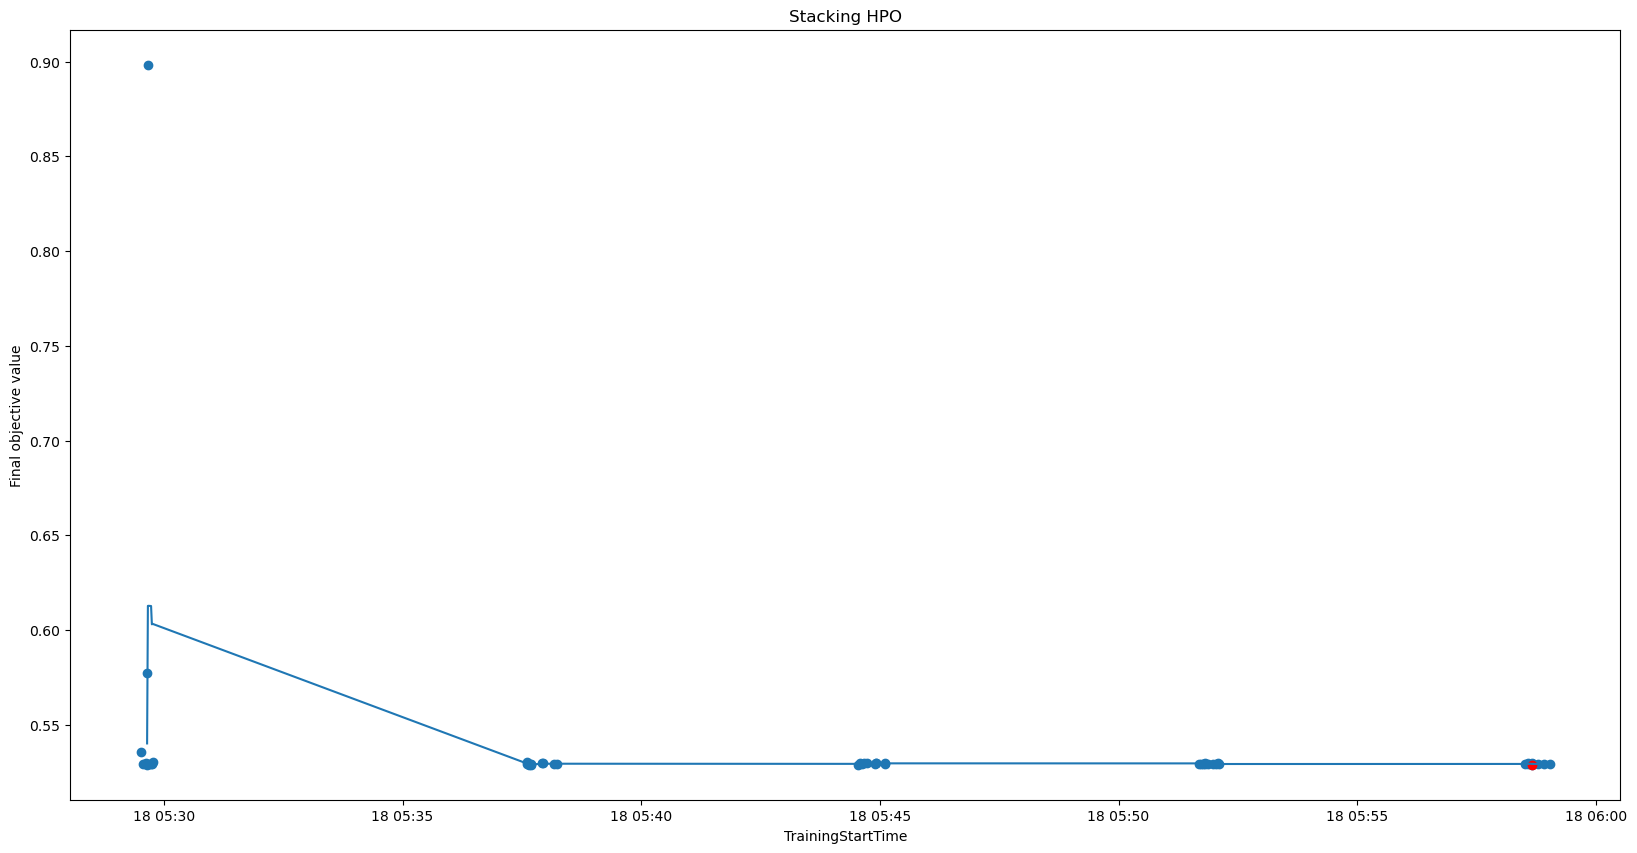

In [15]:
plt.figure(figsize=(20, 10))
# Sort by TrainingStartTime
hpo_results_stacking.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    hpo_results_stacking["TrainingStartTime"],
    hpo_results_stacking["FinalObjectiveValue"],
)
plt.plot(
    hpo_results_stacking["TrainingStartTime"],
    hpo_results_stacking["FinalObjectiveValue"].rolling(5).mean(),
)
# Highlight the best score in red
plt.scatter(
    hpo_results_stacking["TrainingStartTime"][
        hpo_results_stacking["FinalObjectiveValue"].idxmin()
    ],
    hpo_results_stacking["FinalObjectiveValue"].min(),
    c="r",
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("Stacking HPO")
plt.show();

## Inference on Test Set

In [16]:
X_test = pd.read_csv(
    "s3://yang-ml-sagemaker/otto-product-classification/test/test.csv", index_col="id"
).values
X_test.shape

(144368, 93)

### Deploy Best Model

In [17]:
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=stacking_hpo_tuner.best_training_job()
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path}")

Best model artifacts persisted at s3://yang-ml-sagemaker/otto-product-classification/model/stacking-hpo-230618-0527-045-3b866a77/output/model.tar.gz


In [18]:
best_model_name = "best-stacking-model"

# Create model from artifacts
best_stacking_model = Model(
    image_uri=serving_image_uri,
    model_data=best_model_s3_path,
    role=role,
    name=best_model_name,
    sagemaker_session=sagemaker_session,
)

# Deploy model as endpoint
best_stacking_model.deploy(
    initial_instance_count=instance_count, instance_type=instance_type
)

-------------!

Predictor:

In [19]:
predictor = Predictor(
    endpoint_name=best_stacking_model.endpoint_name, sagemaker_session=sagemaker_session
)

Make predictions in batches:

In [20]:
# Define the batch size (number of samples to be sent for inference at once)
batch_size = 1000

# Generate predictions in batches
num_instances = X_test.shape[0]
num_batches = (num_instances + batch_size - 1) // batch_size

predicted_labels = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_instances)
    batch = X_test[start_idx:end_idx]

    # Bytes
    prediction_bytes = predictor.predict(str(batch.tolist()))
    # Deserialize byes to list of lists (one list per sample)
    prediction_lists = json.loads(prediction_bytes)

    # Append the predicted probabilities matrix to the container list
    predicted_labels.append(prediction_lists)

    # Wait 3 seconds before requesting inference predictions for the next batch
    time.sleep(2)

# Concatenate the predicted matrices from all batches
predicted_probabilities = np.concatenate(predicted_labels, axis=0)

predicted_probabilities

100%|██████████| 145/145 [06:01<00:00,  2.49s/it]


array([[1.76392269e-03, 1.50008032e-01, 9.10317612e-02, ...,
        1.09820115e-02, 4.87206291e-05, 1.71544598e-03],
       [3.02831091e-02, 6.00902506e-03, 2.63122606e-03, ...,
        3.06555055e-02, 3.47152235e-01, 2.58355679e-02],
       [2.42110378e-03, 2.82547393e-04, 1.76112222e-04, ...,
        3.86840215e-03, 3.26067214e-03, 3.28398490e-03],
       ...,
       [4.42776677e-04, 8.27288424e-01, 1.42913695e-01, ...,
        4.90348878e-03, 2.60048914e-03, 4.81039927e-04],
       [1.07312014e-03, 4.67530788e-02, 3.49242124e-02, ...,
        6.66259270e-03, 1.23700351e-05, 9.62137232e-04],
       [5.73687209e-04, 5.04937071e-01, 4.45610500e-01, ...,
        1.14950652e-02, 3.25701260e-03, 3.90489216e-04]])

### Write Result to S3

In [26]:
submission = pd.DataFrame(
    predicted_probabilities,
    index=range(1, predicted_probabilities.shape[0] + 1),
    columns=["Class_" + str(i) for i in range(1, predicted_probabilities.shape[1] + 1)],
)

# Upload to s3
submission.to_csv(
    f"s3://{s3_bucket}/{s3_key}/sample-submission/submission.csv", index_label="id"
)

## Clean Up

In [27]:
sm_boto3.delete_endpoint(EndpointName=best_stacking_model.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=best_stacking_model.endpoint_name)
sm_boto3.delete_model(ModelName=best_stacking_model.name)

{'ResponseMetadata': {'RequestId': 'd22a3e38-3837-4592-8500-dadb161e3c9e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd22a3e38-3837-4592-8500-dadb161e3c9e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sun, 18 Jun 2023 06:27:50 GMT'},
  'RetryAttempts': 0}}

In [28]:
del sm_boto3